In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-03-04 17:57:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-03-04 17:57:04 (110 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



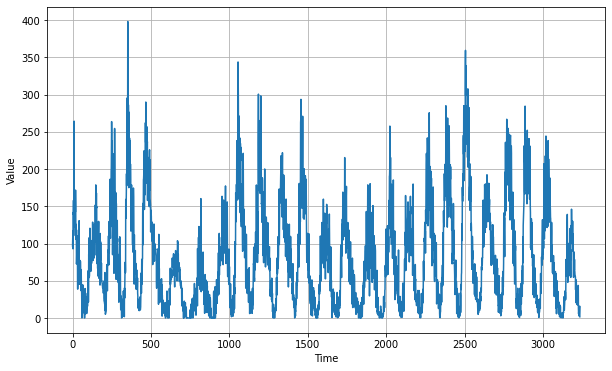

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

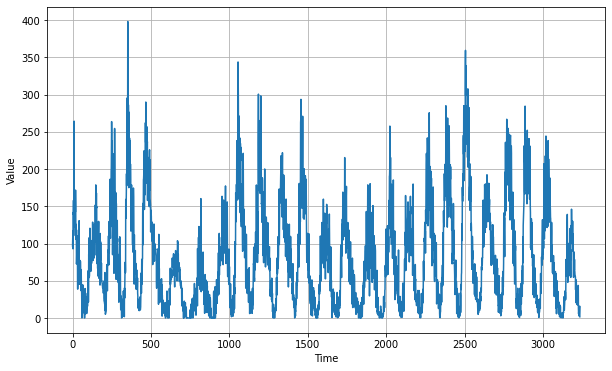

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 50
batch_size = 250
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/150
12/12 [==============================] - 5s 55ms/step - loss: 79.3055 - mae: 79.7887
Epoch 2/150
12/12 [==============================] - 1s 58ms/step - loss: 79.7184 - mae: 80.2028
Epoch 3/150
12/12 [==============================] - 1s 56ms/step - loss: 80.2728 - mae: 80.7562
Epoch 4/150
12/12 [==============================] - 1s 59ms/step - loss: 79.2366 - mae: 79.7210
Epoch 5/150
12/12 [==============================] - 1s 59ms/step - loss: 79.0091 - mae: 79.4927
Epoch 6/150
12/12 [==============================] - 1s 60ms/step - loss: 79.2614 - mae: 79.7453
Epoch 7/150
12/12 [==============================] - 1s 61ms/step - loss: 79.7343 - mae: 80.2186
Epoch 8/150
12/12 [==============================] - 1s 58ms/step - loss: 79.4824 - mae: 79.9665
Epoch 9/150
12/12 [==============================] - 1s 58ms/step - loss: 79.3801 - mae: 79.8639
Epoch 10/150
12/12 [=====

In [11]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

print(minmax(history.history["lr"]))
print(minmax(history.history["loss"]))

(1e-08, 0.2818383)
(48.87253952026367, 281.8740539550781)


(1e-08, 0.3018383, 30.0, 85.0)

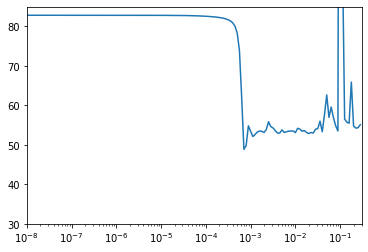

In [12]:
#updated_loss=history.history["loss"]*400
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-08, 0.3018383 , 30, 85])


In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  
  #tf.keras.layers.LSTM(256, return_sequences=True),                    
  #tf.keras.layers.LSTM(128, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=700)

Epoch 1/700
30/30 [==============================] - 14s 94ms/step - loss: 77.5203 - mae: 78.0050
Epoch 2/700
30/30 [==============================] - 2s 77ms/step - loss: 61.6438 - mae: 62.1412
Epoch 3/700
30/30 [==============================] - 2s 76ms/step - loss: 47.5992 - mae: 48.0969
Epoch 4/700
30/30 [==============================] - 2s 77ms/step - loss: 50.0967 - mae: 50.5944
Epoch 5/700
30/30 [==============================] - 2s 77ms/step - loss: 51.5005 - mae: 51.9985
Epoch 6/700
30/30 [==============================] - 2s 77ms/step - loss: 49.9022 - mae: 50.4003
Epoch 7/700
30/30 [==============================] - 2s 76ms/step - loss: 50.3697 - mae: 50.8678
Epoch 8/700
30/30 [==============================] - 2s 77ms/step - loss: 61.5962 - mae: 62.0937
Epoch 9/700
30/30 [==============================] - 2s 77ms/step - loss: 51.5806 - mae: 52.0788
Epoch 10/700
30/30 [==============================] - 2s 78ms/step - loss: 52.2074 - mae: 52.7055
Epoch 11/700
30/30 [========

In [30]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

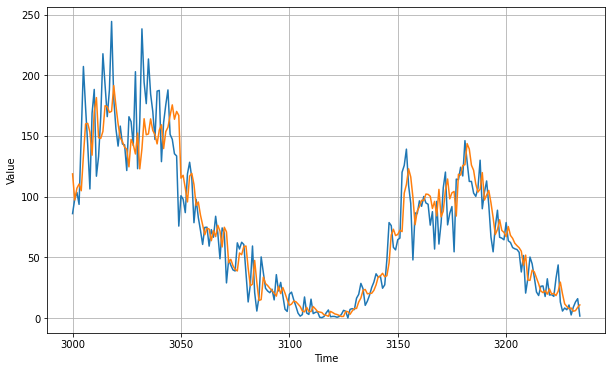

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.182606

<Figure size 432x288 with 0 Axes>

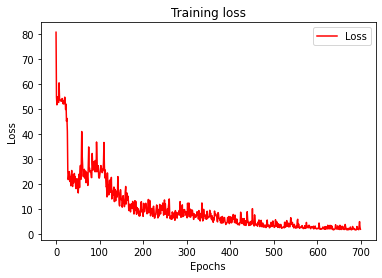

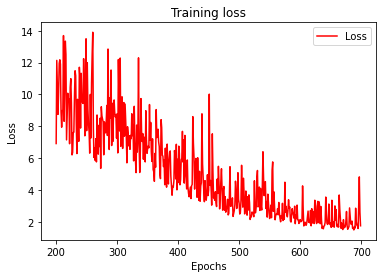

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,700)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [33]:
print(rnn_forecast)

[118.72546    97.193214  106.87888   110.34904   104.83221   133.55307
 159.87823   160.33398   153.12537   134.12248   169.95529   181.58594
 148.53117   147.92778   153.71323   174.92657   173.99815   169.35452
 170.28085   191.465     174.86224   160.04532   148.3967    145.33658
 140.6159    139.03697   124.52094   147.1294    142.92715   135.1214
 152.32895   122.8451    139.44214   164.16872   150.95148   151.63318
 164.04279   154.43672   151.21378   143.41492   154.77905   159.1745
 139.57376   153.56013   157.11273   166.83014   175.58516   163.72177
 170.17854   166.86076   115.19664   117.54422   106.95365    95.61565
 116.89332   119.14467   110.00661    92.59304    95.54298    84.79807
  76.624374   68.538765   73.87189    73.29296    63.6508     72.058334
  67.04314    76.35647    71.58724    58.520733   74.74346    70.90864
  45.515053   48.293858   43.02098    40.010777   38.72694    53.578106
  52.1402     58.78943    59.27923    41.17863    26.561161   27.837833
  47.